**Author**: Justine Debelius (justine.debelius@ki.se)<br>
**Date**: Summer/Fall 2021<br>
**Conda enviroment**: `micc-2020.6`<br>
**Python version**: 3.6.10<br>
**Python packages**: `pystan` (v. 2.19); `patsy` (0.5.1); <br>
**QIIME 2 version**: 2020.6<br>
**QIIME 2 plugins**: `gemeilli` (v. 0.0.7); `deicode` (v. 0.2.4)'; `empress` (v 1.1.0.dev); `songbird` (v. 1.0.4)<br>


# Notebook set up

In [1]:
import itertools as it
import os

import biom
from matplotlib import rcParams
from matplotlib.ticker import StrMethodFormatter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pandas as pd
import patsy
import scipy
import skbio
import statsmodels.api as sms
import statsmodels.formula.api as smf
import seaborn as sn

from qiime2 import Artifact, Metadata, Visualization

import qiime2.plugins.diversity.actions as q2_diversity
import qiime2.plugins.deicode.actions as q2_deicode
import qiime2.plugins.emperor.actions as q2_emperor
import qiime2.plugins.feature_table.actions as q2_feature_table
import qiime2.plugins.gemelli.actions as q2_gemelli

import scripts.tax_colors as tax_colors

rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['pdf.fonttype'] = 42
rcParams['pdf.use14corefonts'] = True
np.set_printoptions(precision=5)

%matplotlib inline

We'll start by loading the metadata and feature table, and taxonomy using consistent annotation and add in some alpha diversity information.

In [2]:
meta_q2 = Metadata.load('data/metadata_paired.tsv')
meta = meta_q2.to_dataframe()

In [3]:
meta.shape

(202, 16)

In [4]:
table_q2 = Artifact.load('data/tables/phylum_defined_table.qza')
table_q2 = q2_feature_table.filter_features(
    table=table_q2,
     min_frequency=100, 
     min_samples=20,
).filtered_table

In [5]:
table_q2.view(biom.Table).shape

(486, 202)

In [6]:
taxa_q2 = Artifact.load('data/tables/taxonomy.qza')
taxa = taxa_q2.view(pd.Series).apply(lambda x: pd.Series(x.split(';')))
taxa = taxa.loc[list(table_q2.view(biom.Table).ids(axis='observation'))]
taxa.rename(columns={0: 'kingdom', 1: 'phylum', 2: 'class', 3: 'order',
                     4: 'family', 5: 'genus', 6: 'species'}, 
            inplace=True)
taxa['color_group'] = \
    taxa['family'].apply(lambda x: tax_colors.remappings.get(x, 'Other'))
taxa.loc[taxa['family'] == 'f__Family_XI', 'color_group'] = \
    taxa.loc[taxa['family'] == 'f__Family_XI', 'class']

taxa_meta = Metadata(taxa)

We use compositional tensor factorization to generate an ordination that accounts for the intra-individual similarity.

In [7]:
subject_biplot = Artifact.load('data/diversity/ctf/subject_biplot.qza')

In [8]:
subject_biplot.view(skbio.OrdinationResults).samples

,0,1,2
145,-0.261228,0.228576,0.032947
148,-0.297061,0.113645,-0.049194
150,-0.216561,0.136774,-0.056513
152,-0.142479,0.035552,0.055491
160,-0.183122,0.057797,-0.024805
...,...,...,...
507,0.157904,-0.069043,-0.043466
512,0.171006,0.019780,-0.118424
540,0.122727,0.151222,-0.233426
73,0.190900,0.130589,-0.209123


To visualize the ordination, we need a subject metadata file. And then, we can throw this into an emperor plot.

In [9]:
# Builds subject metadata
subject_meta = meta.sort_values(['host_subject_id', 'tissue_type']).copy()
subject_meta.drop_duplicates(['host_subject_id'], inplace=True)
subject_meta.drop(columns=['tissue_type', 'depth'], inplace=True)
subject_meta.set_index('host_subject_id', inplace=True)
subject_meta.index.set_names('id', inplace=True)
subject_meta.drop(columns=['tissue_num'], inplace=True)
subject_meta_q2 = Metadata(subject_meta)

In [11]:
# Buildds ordination
ordination = q2_emperor.biplot(
    subject_biplot,
    sample_metadata=subject_meta_q2,
    feature_metadata=taxa_meta,
    number_of_features=10,
).visualization
ordination.save('output/file_s1_subject_ctf_biplot.qzv')

'output/file_s1_subject_ctf_biplot.qzv'

# Statitics
And then we'll extracct the sample coordinates so we can do statitics. I want to start with permanova on the distance between subjects.

We'll start by verifying the per-subject coordinates match back if we calculate distance from the PCA. (They do.) Then, we calculate an unadjusted permanova, covert the pseudo F to an $R^{2}$ and save that as a table.

In [13]:
sample_pos = subject_biplot.view(skbio.OrdinationResults).samples
sample_dis = skbio.DistanceMatrix.from_iterable(
    iterable=sample_pos.values,
    metric=scipy.spatial.distance.euclidean,
    keys=sample_pos.index.values
)
sample_dis_q2 = Artifact.import_data('DistanceMatrix', sample_dis)

In [14]:
sample_dis.shape

(101, 101)

In [15]:
sample_dis_pcoa = skbio.stats.ordination.pcoa(sample_dis)

In [16]:
old_, new_, m2 = scipy.spatial.procrustes(sample_dis_pcoa.samples.loc[sample_pos.index, ['PC1', 'PC2', 'PC3']],
                         sample_pos.values
                         )
m2

4.461595038666052e-31

In [35]:
np.random.seed(1234)
subject_permanova = pd.DataFrame({
    col: skbio.stats.distance.permanova(sample_dis, subject_meta[col])
    for col in subject_meta_q2.columns.keys() if col not in {'project_name'}
}).T

subject_permanova['R2'] = \
    1 - 1 / (1 + subject_permanova['test statistic'] * 
         (subject_permanova['number of groups'] - 1)  / 
          subject_permanova[['number of groups', 'sample size']].diff(axis=1).values[:, 1]
     )
subject_permanova = subject_permanova.loc[
    ['age_cat', 'sex', 'asa_cat', 'pre_op_treatment',
     'ana_location', 'stage_tnm', 'differentiation_grade', 
     'surgery_year', 'radical_surgery', 'long_survival',
    ]]
subject_permanova['p-adj'] = \
    sms.stats.multipletests(subject_permanova['p-value'], method='fdr_bh')[1]

In [46]:
subject_permanova['R2'].apply(lambda x: f'{x:1.2%}')

age_cat                   3.83%
sex                       1.10%
asa_cat                   2.53%
pre_op_treatment          1.36%
ana_location              3.70%
stage_tnm                 1.95%
differentiation_grade     0.52%
surgery_year             17.57%
radical_surgery           1.04%
long_survival             1.24%
Name: R2, dtype: object

In [41]:
table_s3 = subject_permanova[['R2', 'p-value', 'p-adj']].astype(float).round(3)
table_s3 = table_s3.loc[['age_cat', 'sex', 'asa_cat', 'pre_op_treatment',
                         'ana_location', 'stage_tnm', 'differentiation_grade', 
                         'surgery_year', 'radical_surgery',
                         'long_survival',
                        ]]

In [42]:
table_s3.rename(
    index={"age_cat": 'Age, years',
           'sex': 'Sex',
           'asa_cat': "ASA score",
           'pre_op_treatment': "Pre-operative treatment",
           'ana_location': 'Localization',
           'stage_tnm': 'TNM stage',
           'differentiation_grade': 'Grade of differentiation',
           'surgery_year': 'Period of Surgery',
           'radical_surgery': "Radical Operation",
           'long_survival': 'Survival',
           },
    columns={'R2': 'Variation explained (%)', 
             'p-value': 'crude p-value (999 permutations)', 
             'p-adj': 'adjusted p-value'
            },
    inplace=True)

In [43]:
table_s3.to_csv('output/tables/table_s2_permanova.tsv', sep='\t')

In [44]:
writer = pd.ExcelWriter('output/supplemental_table_sheets.xlsx', engine='openpyxl')

# if os.path.exists('output/supplemental_table_sheets.xlsx'):
#     book = openpyxl.load_workbook('output/supplemental_table_sheets.xlsx')
#     writer.book = book

table_s3.to_excel(writer, sheet_name='Table S2')
writer.save()
writer.close()

In [45]:
table_s3

,Variation explained (%),crude p-value (999 permutations),adjusted p-value
"Age, years",0.038,0.242,0.399
Sex,0.011,0.319,0.399
ASA score,0.025,0.277,0.399
Pre-operative treatment,0.014,0.256,0.399
Localization,0.037,0.080,0.323
TNM stage,0.019,0.097,0.323
Grade of differentiation,0.005,0.950,0.950
Period of Surgery,0.176,0.001,0.010
Radical Operation,0.010,0.389,0.432
Survival,0.012,0.296,0.399


And then we can also maybe look at sample precitions based on the location in rpCA sample

## Plotting

We finish by making the shiny figure for display. The data figure will be rendered leaving a space open for 3D Emperor plots (generated above) to finish in Illustrator. The figure, at size and scale, is large and unwealdy to render. Be prepared to wait. 

In [24]:
pc_loadings = subject_biplot.view(skbio.OrdinationResults).proportion_explained

And the feature positions in the subject-ordination space

In [25]:
feature_coords = pd.concat(axis=1, objs=[
    subject_biplot.view(skbio.OrdinationResults).features.add_prefix('PC'),
    taxa,
])

In [26]:
feature_coords['color_name'] = \
    feature_coords['color_group'].replace(tax_colors.mapped_colors)

In [39]:
feature_coords['condition_num'] = \
    np.sqrt(np.square(feature_coords[['PC0', "PC1", 'PC2']]).sum(axis=1))
feature_coords.sort_values('condition_num', ascending=False, inplace=True)
family_colors = {fam: tax_colors.mapped_colors[fam] 
                 for fam in feature_coords.head(10)['color_group']}
color_order = ['f__Lachnospiraceae', 'f__Ruminococcaceae', 'c__Clostridia', 
               'p__Firmicutes',
               'f__Synergistaceae', 'Other',
              ]

And then we can make a very big, very shiny multi-panel figure. Please not ethat the not-draft mode of this takes _forever_ to run, so be cautious about when you need it at 300 dpi.

In [41]:
subject_coords = pd.concat(axis=1, objs=[
    subject_meta,
    subject_biplot.view(skbio.OrdinationResults).samples.add_prefix('PC')
])

In [42]:
error_kwargs = dict(
    data=subject_coords,
    edgecolor='None',
    s=6,
    alpha=0.8,
    legend=False
)
bp_kwargs = dict(
    linewidth=1,
    # palette=['w'],
    fliersize=0,
    width=0.5,
    boxprops={'facecolor': 'w'},
)
scatter_kwargs = dict(
    s=2.5,
    edgecolor='None',
    marker='.',
#     alpha=0.8,
)
arrow_kwargs = dict(
    linewidth=0,
    width=0.0075,
    length_includes_head=True,
)
feat_scatter_kwargs = dict(
    palette=tax_colors.mapped_colors,
    marker='^',
    s=4,
    edgecolor='None',
#     zorder=1000,
)

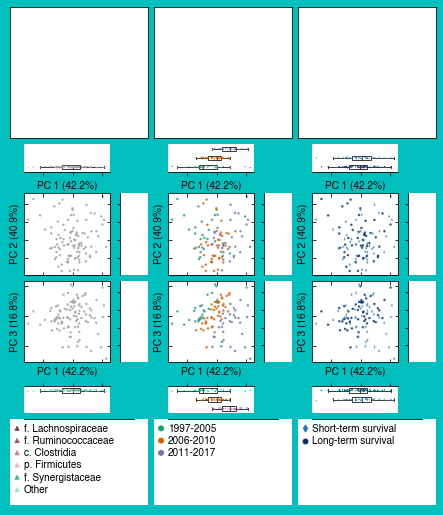

In [50]:
fig = plt.figure(
    constrained_layout=True,
    # dpi=300,
    # facecolor='None',
    facecolor='c',
    figsize=(6,7),
    )
high_fig, med_fig, lo_fig = \
    fig.subfigures(3, 1, height_ratios=np.array([3, 6, 2]) / 11, 
                   hspace=0, facecolor='None')

gs_3d = high_fig.add_gridspec(1, 3)
ax_3d_feat = high_fig.add_subplot(gs_3d[0])
ax_3d_year = high_fig.add_subplot(gs_3d[1])
ax_3d_site = high_fig.add_subplot(gs_3d[2])

for i, ax in enumerate([ax_3d_feat, ax_3d_year, ax_3d_site]):
    # ax.set_xlim([100, 900])
    # ax.set_ylim([700, 100])
    ax.xaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=False)
    ax.yaxis.set_tick_params(left=False, right=False, labelleft=False, labelright=False)
#     sn.despine(ax=ax, left=True, right=True, top=True, bottom=True)
    # ax.text(100 + (800) * 0.05, 
    #         100 + (600) * 0.05, 
    #         'ABC'[i],
    #         size=12,
    #         ha='left',
    #         va='top'
    #         )
    
gs_lo = lo_fig.add_gridspec(1, 3)
ax_leg_feat = lo_fig.add_subplot(gs_lo[0])
ax_leg_year = lo_fig.add_subplot(gs_lo[1])
ax_leg_site = lo_fig.add_subplot(gs_lo[2])

for leg in [ax_leg_feat, ax_leg_year, ax_leg_site]:
    leg.set_ylim([-1.25, 5.75])
    leg.set_xlim([0, 2])
    leg.set_xticks([0.2, 1.8])
    sn.despine(ax=leg, left=True, right=True, top=False, bottom=True, trim=True)
    leg.yaxis.set_tick_params(left=False, labelleft=False, right=False, labelright=False)
    leg.xaxis.set_tick_params(left=False, labelleft=False, right=False, labelright=False)
    
    

ax_leg_feat.scatter(
    x=np.zeros(6) + 0.1,
    y=5 - np.arange(0, 6), 
    c=pd.Series(family_colors)[color_order],
    marker='^',
    s=15,
    )
for i, fam in enumerate(color_order):
    ax_leg_feat.text(
        0.2, 5 - i, 
        fam.replace("__", '. '),
        ha='left', va='center', size=10)
    
ax_leg_year.scatter(
    x=np.zeros(3) + 0.1,
    y=5 - np.arange(0, 3), 
    c=sn.color_palette('Dark2', n_colors=3),
    marker='o',
    s=24,
    )
for i, year in enumerate(sorted(subject_coords['surgery_year'].unique())):
    ax_leg_year.text(0.2, 5 - i, year.split(".")[1], ha='left', va='center', size=10)
    
ax_leg_site.scatter(
    x= 0.1,
    y=5,
    c=['#2171b5'],
    marker='d',
    s=24,
    )
ax_leg_site.scatter(
    x= 0.1,
    y=4,
    c=['#08306b'],
    marker='o',
    s=24,
    )
for i, site in enumerate(['Short-term survival', 'Long-term survival']):
    ax_leg_site.text(0.2, 5 - i, site, ha='left', va='center', size=10)
    


gs = med_fig.add_gridspec(8,12)
    
ax_m_01_feat = med_fig.add_subplot(gs[1:4, 0:3])
ax_0_01_feat = med_fig.add_subplot(gs[0,   0:3], sharex=ax_m_01_feat)
ax_1_01_feat = med_fig.add_subplot(gs[1:4, 3], sharey=ax_m_01_feat)

ax_m_02_feat = fig.add_subplot(gs[4:7, 0:3], sharex=ax_m_01_feat)
ax_0_02_feat = fig.add_subplot(gs[7, 0:3], sharex=ax_m_01_feat)
ax_2_02_feat = fig.add_subplot(gs[4:7, 3], sharey=ax_m_01_feat)

ax_m_01_year = fig.add_subplot(gs[1:4, 4:7], sharex=ax_m_01_feat, sharey=ax_m_01_feat)
ax_0_01_year = fig.add_subplot(gs[0, 4:7], sharex=ax_m_01_feat)
ax_1_01_year = fig.add_subplot(gs[1:4, 7], sharey=ax_m_01_feat)

ax_m_02_year = fig.add_subplot(gs[4:7, 4:7], sharex=ax_m_02_feat, sharey=ax_m_02_feat)
ax_0_02_year = fig.add_subplot(gs[7, 4:7], sharex=ax_m_01_feat)
ax_2_02_year = fig.add_subplot(gs[4:7, 7], sharey=ax_m_01_feat)

ax_m_01_site = fig.add_subplot(gs[1:4, 8:11], sharex=ax_m_01_feat, sharey=ax_m_01_feat)
ax_0_01_site = fig.add_subplot(gs[0, 8:11], sharex=ax_m_01_feat)
ax_1_01_site = fig.add_subplot(gs[1:4, 11], sharey=ax_m_01_feat)

ax_m_02_site = fig.add_subplot(gs[4:7, 8:11],  sharex=ax_m_02_feat, sharey=ax_m_02_feat)
ax_0_02_site = fig.add_subplot(gs[7, 8:11], sharex=ax_m_01_feat)
ax_2_02_site = fig.add_subplot(gs[4:7, 11], sharey=ax_m_01_feat)


feat_ax = [ax_m_01_feat, ax_0_01_feat, ax_1_01_feat,
           ax_m_02_feat, ax_0_02_feat, ax_2_02_feat,
           ]
year_ax = [ax_m_01_year, ax_0_01_year, ax_1_01_year,
           ax_m_02_year, ax_0_02_year, ax_2_02_year,
           ]
site_ax = [ax_m_01_site, ax_0_01_site, ax_1_01_site,
           ax_m_02_site, ax_0_02_site, ax_2_02_site,
           ]


all_axes = [feat_ax, year_ax, site_ax]
grouping_args = [
    {'scatter': dict(hue='project_name', palette=['#9f9f9f']),
     'marg_0': dict(y=subject_coords['project_name']),
     'marg_1': dict(x=subject_coords['project_name']),
     'marg_2': dict(x=subject_coords['project_name']),
     'palette': ['#9f9f9f'],
     },
    {'scatter': dict(hue='surgery_year', palette='Dark2'),#$, style='surgery_year'),
     'marg_0': dict(y=subject_coords['surgery_year']),
     'marg_1': dict(x=subject_coords['surgery_year']),
     'marg_2': dict(x=subject_coords['surgery_year']),
     'palette': 'Dark2',
     },
    {'scatter': dict(hue='long_survival', palette={"0": '#4292c6', '1': '#08306b'},
                     style='long_survival', markers={'0': 'd', '1': 'o'}, sizes={'0': 15, '1': 12}),
     'marg_0': dict(y=subject_coords['long_survival']),
     'marg_1': dict(x=subject_coords['long_survival']),
     'marg_2': dict(x=subject_coords['long_survival']),
     'palette': {"0": '#4292c6', '1': '#08306b'},
     },
]

for axes, kwargs in zip(*(all_axes, grouping_args)):
    ax_m_01, ax_0_01, ax_1_01, ax_m_02, ax_0_02, ax_2_02 = axes
    # plots the main axes
    sn.scatterplot(x='PC0',y='PC1', 
                   ax=ax_m_01, 
                   **error_kwargs,
                   **kwargs['scatter']
                   )
    sn.scatterplot(x='PC0',y='PC2', 
                   ax=ax_m_02, 
                   **error_kwargs,
                   **kwargs['scatter']
                   )
    for ax in [ax_0_01, ax_0_02]:
        sn.boxplot(
            x=subject_coords['PC0'],
            orient='h',
            ax=ax,
            **kwargs['marg_0'],
            **bp_kwargs,
        )
        sn.stripplot(
            x=subject_coords['PC0'],
            orient='h',
            ax=ax,
            palette=kwargs['palette'],
            **kwargs['marg_0'],
            **scatter_kwargs,
        )
    for i, ax in enumerate([ax_1_01, ax_2_02]):
        sn.boxplot(
            y=subject_coords['PC{i}'.format(i=i+1)],
            orient='v',
            ax=ax,
            **kwargs['marg_{i}'.format(i=i+1)],
            **bp_kwargs,
        )
        sn.stripplot(
            y=subject_coords['PC{i}'.format(i=i+1)],
            orient='v',
            ax=ax,
            palette=kwargs['palette'],
            **kwargs['marg_{i}'.format(i=i+1)],
            **scatter_kwargs,
        )
ax_m_01_feat.scatter(feature_coords['PC0'].head(10), 
                     feature_coords['PC1'].head(10), 
                     s=1, 
                     facecolor='None', 
                     edgecolor='None'
                    )
ax_m_02_feat.scatter(feature_coords['PC0'].head(10), 
                     feature_coords['PC2'].head(10), 
                     s=1, 
                     facecolor='None', 
                     edgecolor='None'
                     )

for feat, [pc0, pc1, pc2, color] in feature_coords.head(10)[['PC0', 'PC1', 'PC2', 'color_name']].iterrows():
    ax_m_01_feat.arrow(0, 0, 
                       pc0, 
                       pc1, 
                       color=color,
                       **arrow_kwargs,
                       zorder=1000,
                       )
    ax_m_02_feat.arrow(0, 0, 
                       pc0, 
                       pc2, 
                       color=color,
                       **arrow_kwargs,
                       zorder=1000,
                       )
    ax_m_01_site.arrow(0, 0, 
                       pc0, 
                       pc1, 
                       color='#919191',
                       **arrow_kwargs,
                       zorder=1,
                       alpha=0.25,
                      )
    ax_m_01_year.arrow(0, 0, 
                       pc0, 
                       pc1, 
                       color='#919191',
                       **arrow_kwargs,
                        zorder=1,
                       alpha=0.25,
                      )
    ax_m_02_site.arrow(0, 0, 
                       pc0, 
                       pc2, 
                       color='#919191',
                       **arrow_kwargs,
                        zorder=1,
                       alpha=0.25,
                      )
    ax_m_02_year.arrow(0, 0, 
                       pc0, 
                       pc2, 
                       color='#919191',
                       **arrow_kwargs,
                        zorder=1,
                       alpha=0.25,
                      )
ax_0_01_taxa = ax_0_01_feat.twinx()
ax_0_02_taxa = ax_0_02_feat.twinx()

sn.stripplot(x=feature_coords.head(10)['PC0'],
             y=np.zeros(10),
             hue=feature_coords.head(10)['color_group'],
             orient='h',
             **feat_scatter_kwargs,
             ax=ax_0_01_taxa,
             )
sn.stripplot(x=feature_coords.head(10)['PC0'],
             y=np.zeros(10),
             hue=feature_coords.head(10)['color_group'],
             orient='h',
             **feat_scatter_kwargs,
             ax=ax_0_02_taxa,
             )

for ax in [ax_0_01_taxa, ax_0_02_taxa]:
    ax.legend_.set_visible(False)
    ax.yaxis.set_tick_params(left=False, labelleft=False, 
                             right=False, labelright=False)
    sn.despine(ax=ax, left=True, right=True, top=True, bottom=True)

ax_1_01_taxa = ax_1_01_feat.twiny()
ax_2_02_taxa = ax_2_02_feat.twiny()
sn.stripplot(y=feature_coords.head(10)['PC1'],
             x=np.zeros(10),
             hue=feature_coords.head(10)['color_group'],
             orient='v',
             **feat_scatter_kwargs,
             ax=ax_1_01_taxa,
             )
sn.stripplot(y=feature_coords.head(10)['PC2'],
             x=np.zeros(10),
             hue=feature_coords.head(10)['color_group'],
             orient='v',
             **feat_scatter_kwargs,
             ax=ax_2_02_taxa,
             )
for ax in [ax_1_01_taxa, ax_2_02_taxa]:
    ax.legend_.set_visible(False)
    ax.xaxis.set_tick_params(left=False, labelleft=False, 
                             right=False, labelright=False)
    sn.despine(ax=ax, left=True, right=True, top=True, bottom=True)

for ax in [ax_m_01_feat, ax_m_01_site, ax_m_01_year]:
    ax.set_ylabel('PC 2 ({1:1.1%})'.format(*pc_loadings), size=10)
    ax.set_xlabel('PC 1 ({0:1.1%})'.format(*pc_loadings), size=10)
    ax.xaxis.set_tick_params(left=True, right=True, labelleft=False, 
                             labelright=False,
                             tickdir='in', labelsize=8)
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_tick_params(left=True, right=True, labelleft=False, 
                             tickdir='in', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:>4.2f}"))

    
for ax in [ax_m_02_year, ax_m_02_feat, ax_m_02_site]:
    ax.set_ylabel('PC 3 ({2:1.1%})'.format(*pc_loadings), size=10)
    ax.set_xlabel('PC 1 ({0:1.1%})'.format(*pc_loadings), size=10)
    ax.xaxis.set_tick_params(left=True, right=True, labelleft=False, 
                             tickdir='in', labelsize=8)
#     ax.xaxis.get_label().set_visible(False)
    ax.yaxis.set_tick_params(left=True, right=True, labelleft=False, 
                             tickdir='in', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:>4.2f}"))

for i, ax in enumerate([ax_0_01_feat, ax_0_01_site, ax_0_01_year]):
    sn.despine(ax=ax, left=True, right=True, top=True) 
    ax.xaxis.set_tick_params(bottom=True, top=False, labelbottom=False, labelsize=8)
    ax.xaxis.get_label().set_visible(False)
    ax.yaxis.set_tick_params(left=False, right=False, labelleft=False, length=0, labelsize=8)
    ax.yaxis.get_label().set_visible(False)
    ax.set_ylim([-0.5, 2.5])

    
for ax in [ax_0_02_feat, ax_0_02_year, ax_0_02_site]:
#     ax.set_facecolor('c')
    sn.despine(ax=ax, left=True, right=True, top=False, bottom=True)
    ax.xaxis.set_tick_params(bottom=False, top=True, labelbottom=False, labeltop=False, labelsize=8)
    ax.xaxis.get_label().set_visible(False)
    ax.yaxis.set_tick_params(left=False, right=False, labelleft=False, length=0, labelsize=8)
    ax.yaxis.get_label().set_visible(False)
    ax.set_ylim([2.5, -0.5])
    

for ax in [ax_1_01_feat, ax_1_01_year, ax_1_01_site, ax_2_02_feat, ax_2_02_year, ax_2_02_site]:
    sn.despine(ax=ax, left=False, right=True, top=True, bottom=True)
    ax.yaxis.set_tick_params(bottom=True, top=False, labelbottom=False, labelsize=8)
    ax.xaxis.set_tick_params(left=False, right=False, labelleft=False, length=0, labelsize=8)
    ax.xaxis.get_label().set_visible(False)
    ax.yaxis.get_label().set_visible(False)
    ax.set_xlim([-0.5, 2.5])
    

    
fig.savefig('output/figures/figure_s3_ctf_ord.pdf', facecolor='None')

